In [1]:
import numpy as np 
import pandas as pd
import re
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from scipy import special
from tqdm import tqdm
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, classification_report, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier, LGBMRegressor
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.feature_selection import RFE
from boruta import BorutaPy

warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)

In [2]:
X_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_train_corr.csv')
y_train = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_train_large.csv').squeeze()
X_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/X_test_corr.csv')
y_test = pd.read_csv('/Users/sakshamjain/Desktop/Projects/JAIN-WIN/y_test_large.csv').squeeze()

In [3]:
X_train.head()

,age,bmi,elective_surgery,gender,height,icu_id,pre_icu_los_days,weight,albumin_apache,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,arf_apache,bilirubin_apache,bun_apache,creatinine_apache,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,glucose_apache,heart_rate_apache,hematocrit_apache,intubated_apache,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,ph_apache,resprate_apache,sodium_apache,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_heartrate_max,d1_heartrate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_resprate_max,d1_resprate_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_heartrate_max,h1_heartrate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_resprate_max,h1_resprate_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,d1_albumin_max,d1_albumin_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_sodium_max,d1_sodium_min,d1_wbc_max,d1_wbc_min,h1_albumin_max,h1_albumin_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_sodium_max,h1_sodium_min,h1_wbc_max,h1_wbc_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_id_counts,age_counts,nan_counts,sq_age,sq_bmi,bmi_age,weight_age,comorbidity_score,diabete_risk,gcs_sum,apache_2_diagnosis_type,bmi_type,height_type,weight_type,age_type,gcs_sum_type,apache_3j_diagnosis_split1,apache_2_diagnosis_split1,profile,diff_bmi,bilirubin_d1_h1_max_eq,bilirubin_d1_h1_min_eq,bilirubin_h1_value_range,bilirubin_h1_zero_range,bilirubin_h1_mean,bilirubin_h1_std,bilirubin_h1_max_apache_3j_diagnosis_mean,bilirubin_h1_max_apache_3j_diagnosis_diff,bilirubin_h1_max_apache_3j_diagnosis_std,bilirubin_h1_max_apache_3j_diagnosis_norm_std,bilirubin_h1_max_apache_3j_diagnosis_rank,bilirubin_h1_max_apache_3j_diagnosis_count,bilirubin_h1_max_apache_3j_diagnosis_norm_rank,bilirubin_h1_max_apache_3j_diagnosis_skew,bilirubin_h1_min_apache_3j_diagnosis_mean,bilirubin_h1_min_apache_3j_diagnosis_diff,bilirubin_h1_min_apache_3j_diagnosis_std,bilirubin_h1_min_apache_3j_diagnosis_norm_std,bilirubin_h1_min_apache_3j_diagnosis_rank,bilirubin_h1_min_apache_3j_diagnosis_norm_rank,bilirubin_h1_min_apache_3j_diagnosis_skew,bilirubin_h1_max_profile_mean,bilirubin_h1_max_profile_diff,bilirubin_h1_max_profile_std,bilirubin_h1_max_profile_norm_std,bilirubin_h1_max_profile_rank,bilirubin_h1_max_profile_count,bilirubin_h1_max_profile_norm_ran

In [4]:
print("Training LightGBM model...")
model = lgb.LGBMClassifier( random_state=69, n_jobs=-1, force_col_wise=True )
# Train the initial LightGBM model
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate classification metrics
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_report(y_test, y_pred))

Training LightGBM model...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 850113
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 3698
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
AUC-ROC: 0.8720636771207815
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048



In [5]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for importance
importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Calculate cumulative importance
importance_df['cumulative_importance'] = importance_df['importance'].cumsum() / importance_df['importance'].sum()

# Select features contributing to 95% of cumulative importance
selected_features = importance_df[importance_df['cumulative_importance'] <= 0.95]['feature']

# Filter the train and test sets for selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Retrain the model using the selected features
model_selected = lgb.LGBMClassifier(random_state=69, n_jobs=-1, force_col_wise=True)

# Train the model again on the selected features
model_selected.fit(X_train_selected, y_train)

# Make predictions and evaluate the model
y_pred_selected = model_selected.predict_proba(X_test_selected)[:, 1]
auc_roc_selected = roc_auc_score(y_test, y_pred_selected)

print(f"AUC-ROC on the selected features: {auc_roc_selected}")

[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 311277
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1277
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
AUC-ROC on the selected features: 0.8723564971241229


In [6]:
X_train=X_train_selected.copy()
X_test=X_test_selected.copy()

In [13]:
print("Training LightGBM model...")
model = lgb.LGBMClassifier( random_state=69, n_jobs=-1, force_col_wise=True )
# Train the initial LightGBM model
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Calculate classification metrics
auc_roc = roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC:", auc_roc)
print("Classification Report:\n", classification_report(y_test, y_pred))

Training LightGBM model...
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Total Bins 311277
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1277
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
AUC-ROC: 0.8723564971241229
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048



LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


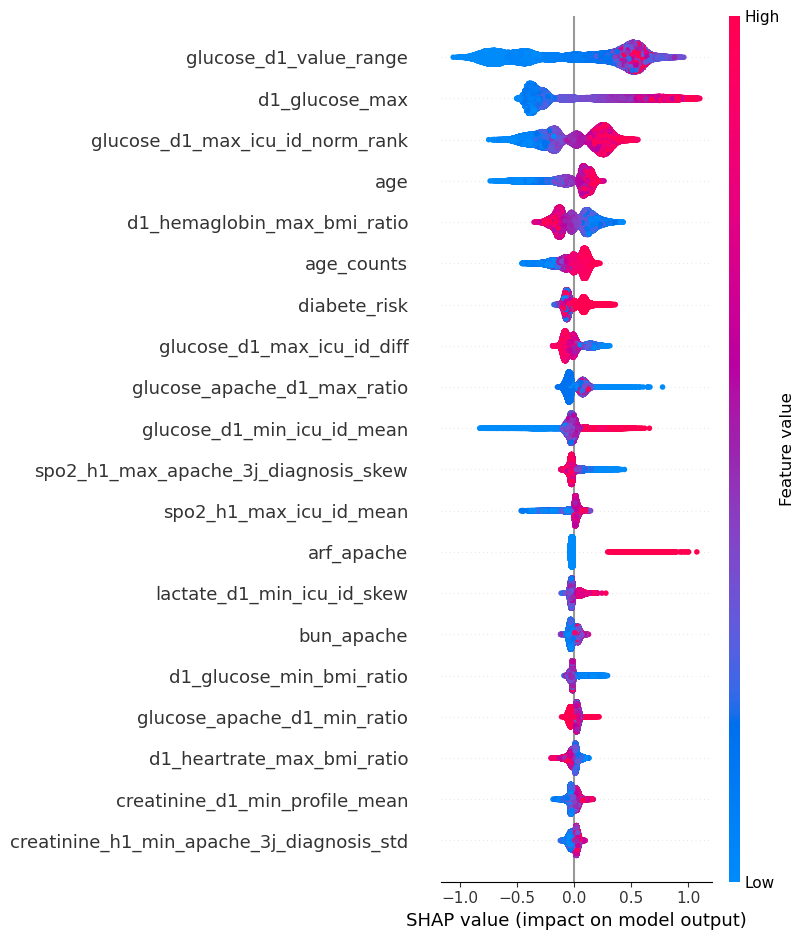

In [14]:
import shap

explainer = shap.TreeExplainer(model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Plot summary of SHAP values to visualize the most important features
shap.summary_plot(shap_values[1], X_train, feature_names=X_train.columns)

In [17]:
shap_importance = np.abs(shap_values[1]).mean(axis=0)  # Index 1 for positive class in binary classification

# Get feature names and their importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_importance
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

# Calculate cumulative importance
feature_importance['cumulative_importance'] = feature_importance['importance'].cumsum() / feature_importance['importance'].sum()

# Set threshold for cumulative importance (e.g., 95%)
threshold = 0.95
top_n = feature_importance[feature_importance['cumulative_importance'] <= threshold]

# Select top n important features
n = 1277
top_n_features = top_n['feature']

# Subset the training and testing data to these top n features
X_train_top_n = X_train[top_n_features]
X_test_top_n = X_test[top_n_features]

# Retrain the LightGBM model with the top n features
model_top_n = lgb.LGBMClassifier()
model_top_n.fit(X_train_top_n, y_train)

# Make predictions on the test set
y_pred = model_top_n.predict(X_test_top_n)
y_pred_proba = model_top_n.predict_proba(X_test_top_n)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

Selected top 1277 features to cover 95.0% of cumulative SHAP importance.
[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141469
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 587
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048

AUC-ROC: 0.8714


In [23]:
shap_importance = np.abs(shap_values[1]).mean(axis=0)  # Index 1 for positive class in binary classification

# Get feature names and their importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': shap_importance
})

# Sort by importance
feature_importance = feature_importance.sort_values(by='importance', ascending=False)


n = 1279# You can adjust this value
top_n_features = feature_importance['feature'].head(n)

# Subset the training and testing data to these top n features
X_train_top_n = X_train[top_n_features]
X_test_top_n = X_test[top_n_features]

# Retrain the LightGBM model with the top n features
model_top_n = lgb.LGBMClassifier()
model_top_n.fit(X_train_top_n, y_train)

# Make predictions on the test set
y_pred = model_top_n.predict(X_test_top_n)
y_pred_proba = model_top_n.predict_proba(X_test_top_n)[:, 1]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_roc:.4f}")

[LightGBM] [Info] Number of positive: 19677, number of negative: 71432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.407193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 311277
[LightGBM] [Info] Number of data points in the train set: 91109, number of used features: 1277
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215972 -> initscore=-1.289296
[LightGBM] [Info] Start training from score -1.289296
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90     30574
         1.0       0.69      0.50      0.58      8474

    accuracy                           0.84     39048
   macro avg       0.78      0.72      0.74     39048
weighted avg       0.83      0.84      0.83     39048

AUC-ROC: 0.8712
